# Save the LOFAR combined Gaussians catalogue

This notebook can retrieve the saved data and create the combined final catalogue. It is very useful if the main notebook crashed.

In [1]:
import numpy as np
from astropy.table import Table, join
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import pickle
import os

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from mltier1 import (get_center, get_n_m, estimate_q_m, Field, SingleMLEstimator, MultiMLEstimator,
                     parallel_process, get_sigma, get_q_m, get_threshold)

In [4]:
lofar = Table.read("idata/gaus/lofar_m2.fits")

In [5]:
q0_total = 0.67849530821823023

In [6]:
threshold = np.percentile(lofar["lr_2"], 100*(1 - q0_total))

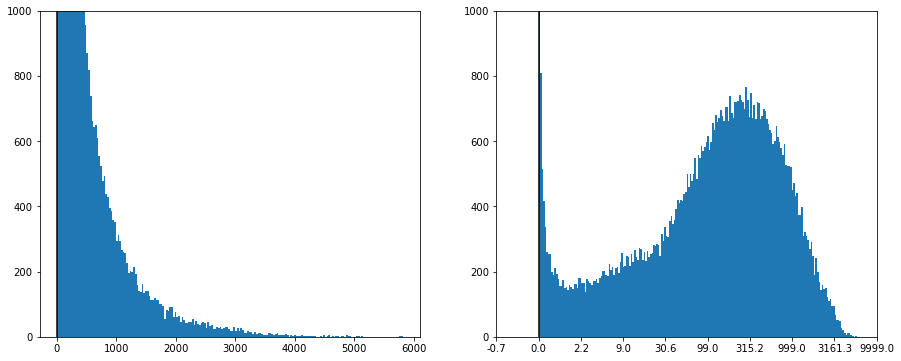

In [8]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_2"] != 0]["lr_2"], bins=200)
vlines([threshold], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_2"] != 0]["lr_2"]+1), bins=200)
vlines(np.log10(threshold+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [9]:
lofar["lr_index_sel_2"] = lofar["lr_index_2"]
lofar["lr_index_sel_2"][lofar["lr_2"] < threshold] = np.nan

In [10]:
combined = Table.read("pw.fits")

In [12]:
combined["colour"] = combined["i"] - combined["W1mag"]

In [13]:
combined_matched = (~np.isnan(combined["i"]) & ~np.isnan(combined["W1mag"])) # Matched i-W1 sources
combined_panstarrs = (~np.isnan(combined["i"]) & np.isnan(combined["W1mag"])) # Sources with only i-band
combined_wise =(np.isnan(combined["i"]) & ~np.isnan(combined["W1mag"])) # Sources with only W1-band
combined_i = combined_matched | combined_panstarrs
combined_w1 = combined_matched | combined_wise

In [14]:
colour_limits = [-0.5, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0]

In [15]:
# Start with the W1-only, i-only and "less than lower colour" bins
colour_bin_def = [{"name":"only W1", "condition": combined_wise},
                  {"name":"only i", "condition": combined_panstarrs},
                  {"name":"-inf to {}".format(colour_limits[0]), 
                   "condition": (combined["colour"] < colour_limits[0])}]

# Get the colour bins
for i in range(len(colour_limits)-1):
    name = "{} to {}".format(colour_limits[i], colour_limits[i+1])
    condition = ((combined["colour"] >= colour_limits[i]) & 
                 (combined["colour"] < colour_limits[i+1]))
    colour_bin_def.append({"name":name, "condition":condition})

# Add the "more than higher colour" bin
colour_bin_def.append({"name":"{} to inf".format(colour_limits[-1]), 
                       "condition": (combined["colour"] >= colour_limits[-1])})

/home/jsm/programs/soft/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/home/jsm/programs/soft/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater_equal
/home/jsm/programs/soft/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/home/jsm/programs/soft/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater_equal


In [16]:
combined["category"] = np.nan
for i in range(len(colour_bin_def)):
    combined["category"][colour_bin_def[i]["condition"]] = i

In [17]:
combined["lr_index_sel_2"] = np.arange(len(combined)).astype(float)

In [18]:
combined["i"].fill_value = 1e+20
combined["W1mag"].fill_value = 1e+20
combined["colour"].fill_value = 1e+20
combined["category"].fill_value = 999999

In [19]:
lofar.remove_column("i")
lofar.remove_column("category")
lofar.remove_column("W1mag")

In [20]:
lofar_combined = join(lofar, combined, join_type='left', keys='lr_index_sel_2')

In [21]:
for col in lofar_combined.colnames:
    try:
        print(col, lofar_combined[col].fill_value)
    except AttributeError:
        print(col, "NO_FILL")

Source_Name N/A
RA 1e+20
E_RA 1e+20
E_RA_tot 1e+20
DEC 1e+20
E_DEC 1e+20
E_DEC_tot 1e+20
Peak_flux 1e+20
E_Peak_flux 1e+20
E_Peak_flux_tot 1e+20
Total_flux 1e+20
E_Total_flux 1e+20
E_Total_flux_tot 1e+20
Maj 1e+20
E_Maj 1e+20
Min 1e+20
E_Min 1e+20
PA 1e+20
E_PA 1e+20
Isl_rms 1e+20
S_Code N/A
Mosaic_ID N/A
Gaus_id 999999
Isl_id 999999
Source_id 999999
lr_i 1e+20
lr_dist_i 1e+20
lr_index_i 1e+20
lr_index_sel_i 1e+20
lr_w1 1e+20
lr_dist_w1 1e+20
lr_index_w1 1e+20
lr_index_sel_w1 1e+20
lr_index_1 1e+20
lr_dist_1 1e+20
lr_1 1e+20
lr_type_1 999999
lr_index_2 1e+20
lr_dist_2 1e+20
lr_2 1e+20
lr_index_sel_2 1e+20
AllWISE N/A
objID -99
ra 1e+20
dec 1e+20
raErr 1e+20
decErr 1e+20
W1mag 1e+20
W1magErr 1e+20
i 1e+20
iErr 1e+20
colour 1e+20
category 999999.0


In [22]:
lofar_combined.write("lofar_matched_gaus.fits", format="fits")